In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization
import torchvision.transforms.functional as TF

In [2]:
from google.colab import drive
drive.mount(('/content/drive'))

Mounted at /content/drive


In [3]:
%%time

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

CPU times: user 19.9 s, sys: 10.4 s, total: 30.3 s
Wall time: 59.6 s


In [4]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# List files in each subfolder
print("Train files:", os.listdir(train_path))
print("Test files:", os.listdir(test_path))
print("Validation files:", os.listdir(validation_path))
print("__________________________________________")

# print("Train images:", os.listdir(train_images_path))
# print("Test images:", os.listdir(test_images_path))
# print("Validation images:", os.listdir(validation_images_path))
# print("__________________________________________")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

# print("Train landmarks:", os.listdir(train_landmarks_path))
# print("Test landmarks:", os.listdir(test_landmarks_path))
# print("Validation landmarks:", os.listdir(validation_landmarks_path))
# print("__________________________________________")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")[:1500]
test_labels_path = os.path.join(test_path, "labels")[:400]
validation_labels_path = os.path.join(validation_path, "labels")[:200]

# print("Train labels:", os.listdir(train_labels_path))
# print("Test labels:", os.listdir(test_labels_path))
# print("Validation labels:", os.listdir(validation_labels_path))
# print("__________________________________________")

Train files: ['images', 'landmarks', 'labels']
Test files: ['images', 'landmarks', 'labels']
Validation files: ['images', 'landmarks', 'labels']
__________________________________________


In [5]:
# Save checkpoint
def save_checkpoint(state,filename='UNET.weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim):
    print('Loading weights-->')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [6]:
'''   NOT USED   '''


# We need to generate 1 single mask from all masks
# First we retrieve all masks associated with current image

def generate_image_from_masks(mask,original_image):
    custom_colors = np.array([
    [0, 0, 0],
    [0, 153, 255],
    [102, 255, 153],
    [0, 204, 153],
    [255, 255, 102],
    [255, 255, 204],
    [255, 153, 0],
    [255, 102, 255],
    [102, 0, 51],
    [255, 204, 255],
    [255, 0, 102]])
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            rgb_image[y, x] = custom_colors[class_value]
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [7]:
# Data Visualization
i = 22
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
# mask_img = cv2.resize(mask_img, (512, 512))
# mask_img = generate_image_from_masks(mask_img,image_rgb)

print(image_bgr.shape)
print(mask_img.shape)

(1166, 1158, 3)
(1166, 1158)


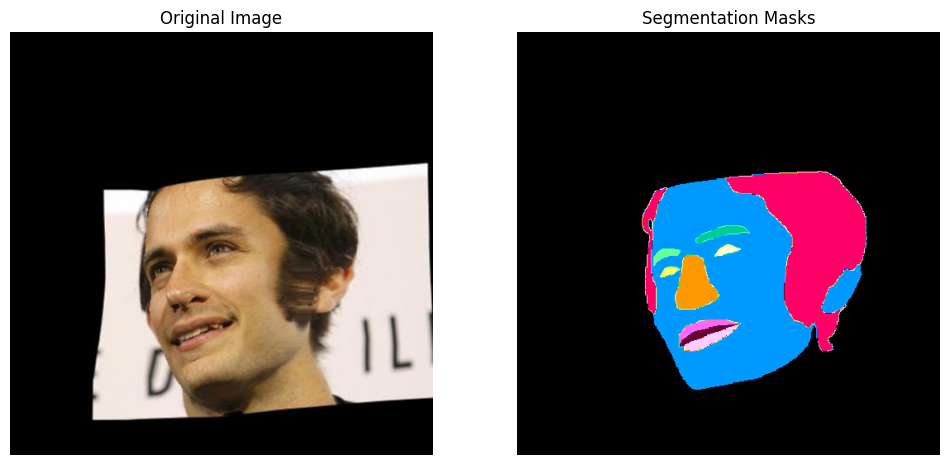

In [8]:
# Data Visualization
i = 90
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

# LAPA + transform

In [9]:
def my_img_mask_transforms(image, mask):
    resize = transforms.Resize((512, 512))
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    image = resize(image)
    mask = resize(mask)

    seed = np.random.randint(2147483647)
    random.seed(seed)
    torch.manual_seed(seed)

    if random.random() > 0.5:
          angle = random.randint(-30, 30)
          image = TF.rotate(image, angle)
          mask = TF.rotate(mask, angle)

    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    image = totensor(image)
    image = normalize(image)
    mask = torch.tensor(np.array(mask), dtype=torch.float32)

    return image, mask



class Lapa(Dataset):
    def __init__(self, images_dir, masks_dir, size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images", "labels").replace("jpg", "png")

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Open mask and convert to PIL Image
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = Image.fromarray(cv2.resize(mask_img, (512, 512)))


        image, mask_img = my_img_mask_transforms(image, mask_img)

        # Split the masks
        binary_masks = []
        for class_value in range(0, 11):
            binary_mask = (mask_img == class_value).float()
            binary_masks.append(binary_mask)

        return image, torch.stack(binary_masks, dim=0)

In [10]:
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1100)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   250)


Image 0 is tensor: True


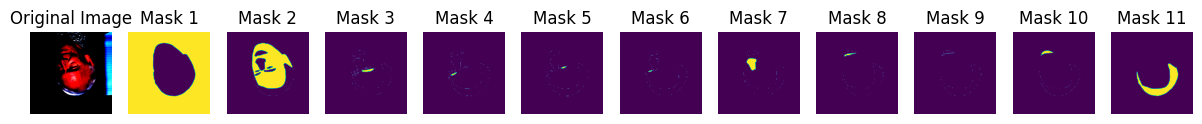

Image 1 is tensor: True


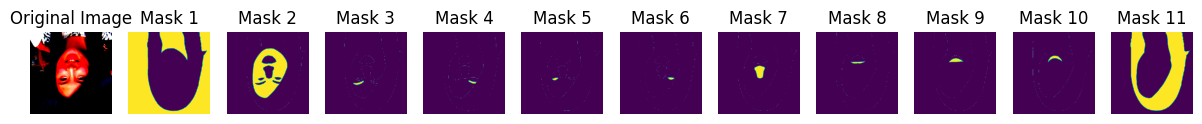

Image 2 is tensor: True


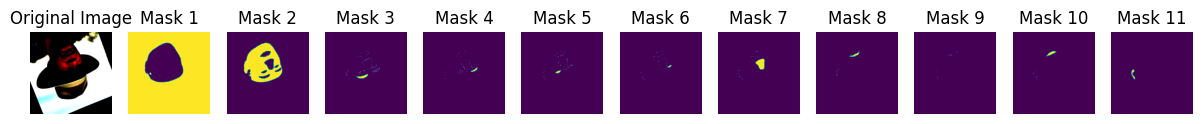

Image 3 is tensor: True


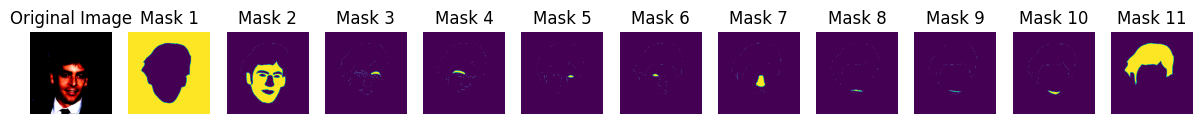

Image 4 is tensor: True


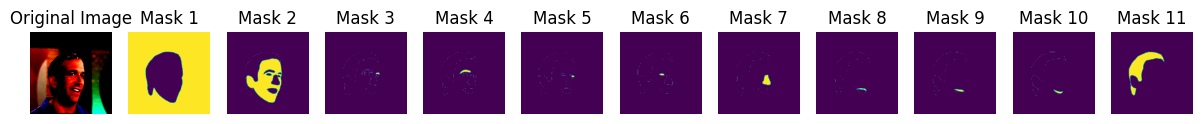

In [11]:
for i in range(5):  # Change the range as needed
    t = train_dataset[i]
    img = np.array(t[0].permute(1, 2, 0))
    print(f"Image {i} is tensor: {isinstance(t[1], torch.Tensor)}")
    mask = np.array(t[1])

    num_masks = mask.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 15))

    # Display the original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each mask
    for m in range(num_masks):
        axes[m + 1].imshow(mask[m])
        axes[m + 1].set_title(f'Mask {m + 1}')
        axes[m + 1].axis('off')

    plt.show()

# Train/Val loader - train_loop - test_loop

In [12]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
def train_loop(model,dataloader,loss_fun,optimizer, num_epochs,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch + 1, moving_loss))

In [14]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

# UNET

In [15]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]

        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]

        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]

        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]

        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]

        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]

        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]

        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]

        return X22 #F.softmax(X22,dim=1)

In [16]:
model = VanillaUNet(in_channels=3,num_classes=11)

In [17]:
# Params
learning_rate = 0.00005
num_epochs = 5
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [18]:
# Define Criterion, Loss function, LR Scheduler
criterion = nn.BCEWithLogitsLoss()
# criterion = CustomLoss()
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
''' IF YOU WANT '''
# load_checkpoint("/content/UNET.weights.pth.tar",model,optimizer)

In [ ]:
train_loop(model,dataloader,loss_fun,optimizer, num_epochs,device):

In [19]:
train_loop(model,train_loader,criterion,optimizer, num_epochs, device)

Epoch [0/5] : 100%|██████████| 550/550 [05:17<00:00,  1.73it/s, loss=0.125]


Saving weights-->
Epoch 1 : Loss = 0.25738794493404304


Epoch [1/5] : 100%|██████████| 550/550 [05:20<00:00,  1.72it/s, loss=0.0945]


Saving weights-->
Epoch 2 : Loss = 0.10703535016287456


Epoch [2/5] : 100%|██████████| 550/550 [05:19<00:00,  1.72it/s, loss=0.108]


Saving weights-->
Epoch 3 : Loss = 0.09908038356087424


Epoch [3/5] : 100%|██████████| 550/550 [05:19<00:00,  1.72it/s, loss=0.0657]


Saving weights-->
Epoch 4 : Loss = 0.09522503984245387


Epoch [4/5] : 100%|██████████| 550/550 [05:19<00:00,  1.72it/s, loss=0.082]


Saving weights-->
Epoch 5 : Loss = 0.09205612424422394


In [20]:
test_loop(model, val_loader, criterion,device)

100%|██████████| 125/125 [00:31<00:00,  4.00it/s, loss=0.0644]


In [21]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [22]:
def compute_metrics(pred_masks, true_masks):
    iou_scores = []
    dice_scores = []

    for pred_mask, true_mask in zip(pred_masks, true_masks):
        pred_mask, true_mask = pred_mask.detach().cpu(), true_mask.cpu()
        threshold = 0
        pred_mask = (pred_mask > threshold).int()
        true_mask = true_mask.int()
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)

        dice = 2 * intersection / (pred_mask.sum() + true_mask.sum())
        dice_scores.append(dice)

    mIoU = np.mean(iou_scores)

    return iou_scores, dice_scores, mIoU

In [23]:
iou_scores, dice_scores, mIoU = compute_metrics(pred, mask)
print(iou_scores, dice_scores, mIoU)

[tensor(0.7189), tensor(0.6590)] [tensor(0.8365), tensor(0.7945)] 0.68898535


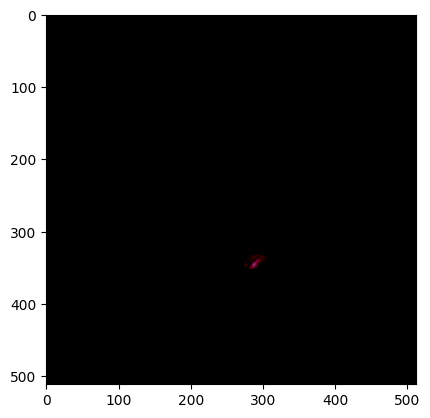

In [24]:
img = np.array(image[0].permute(1,2,0).cpu())
plt.imshow(img)

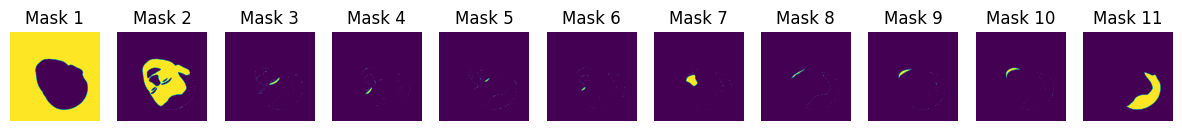

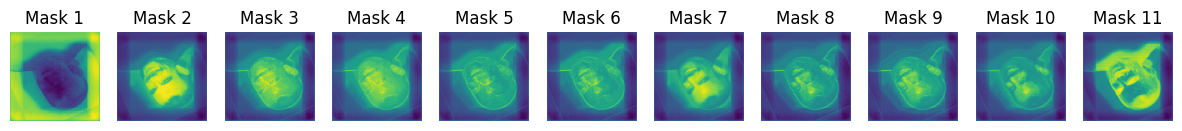

In [25]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[0][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[0][m].detach().cpu().numpy())
        axes1[m].set_title(f'Mask {m + 1}')
        axes1[m].axis('off')


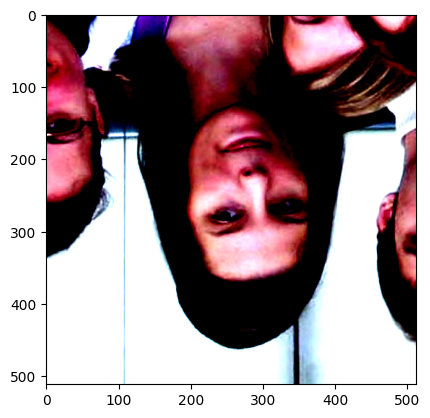

In [26]:
img = np.array(image[1].permute(1,2,0).cpu())
plt.imshow(img)

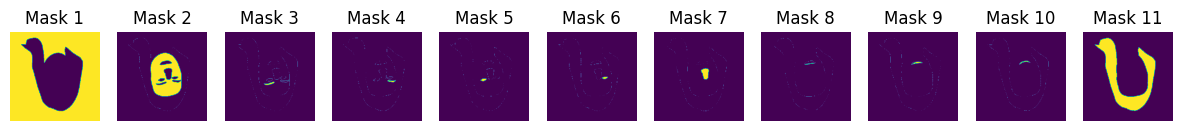

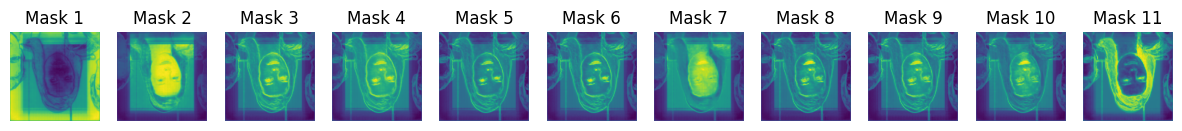

In [27]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'Mask {m + 1}')
        axes1[m].axis('off')
